In [1]:
import argparse
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from utils.GNN_data import *
from utils.GNN_model import GIN
from utils.train_model import train_model
from utils.evaluate_model import *

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--batch_num', type=int, default=64, help='batch size') 
parser.add_argument('--epoch_num', type=int, default=200, help='Epoch number') 
parser.add_argument('--cover_interval', type=int, default=20, help='Cover interval')
parser.add_argument('--overlap', type=float, default=0.3, help='cover overlap')
parser.add_argument('--save_model_dir', type=str, default='./examples/saved_GNN_model', help='saved GNN model directory')
args = parser.parse_args([])

In [3]:
from torch_geometric.data import Data
import torch 
def load_inp_data(file_path, label):
    nodes, edges = [], []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()

        node_section = False
        element_section = False

        for line in lines:
            line = line.strip()

            if "*Node" in line:
                node_section = True
                element_section = False
                continue

            if "*Element" in line:
                node_section = False
                element_section = True
                continue

            # Skip invalid lines like "*Nset" or "*Elset"
            if "*Nset" in line or "*Elset" in line:
                node_section = False
                element_section = False
                continue

            if node_section:
                parts = line.split(',')
                if len(parts) >= 3:
                    try:
                        x, y = float(parts[1].strip()), float(parts[2].strip())
                        nodes.append([x, y])
                    except ValueError:
                        continue

            if element_section:
                parts = line.split(',')
                if len(parts) >= 3 and parts[0].strip().isdigit() and parts[1].strip().isdigit() and parts[2].strip().isdigit():
                    start, end = int(parts[1].strip()) - 1, int(parts[2].strip()) - 1  # Convert 1-indexed to 0-indexed
                    
                    if start == end:
                        continue
                    
                    # Ensure indices are within valid range
                    if start < len(nodes) and end < len(nodes):
                        edges.append([start, end])
                    else:
                        print(f"Skipping invalid edge ({start+1}, {end+1}) in {file_path}")

    node_tensor = torch.tensor(nodes, dtype=torch.float)
    edge_tensor = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)

    data = Data(x=node_tensor, edge_index=edge_tensor, K=np.float64(label * 200000.00))
    return data

# Data loading

In [4]:
import glob

# Read the Result.txt file and extract filenames and their labels
file_labels = {}
with open('Results.txt', 'r') as file:
    for line in file:
        # Skip empty lines or lines starting with a header
        if line.strip() == "" or "E/Es" in line:
            continue
        
        try:
            file, label = line.strip().split(', ')
            filename, filetype = file.strip().split('.')
            label = float(label)  # Convert the label to a float
            file_labels[filename] = label
        except ValueError:
            print(f"Skipping line due to invalid format: {line.strip()}")

# Load all data points using the filenames and labels from the file_labels dictionary
dataset = [load_inp_data(f"inp_files/{file}.inp", label) for file, label in file_labels.items()]

# Print out the loaded data
for file, label in file_labels.items():
    print(f"Filename: {file}, E/Es: {label}")

Filename: Demi-A10L_R00_n01, E/Es: 0.0146144422743
Filename: Demi-A10L_R01_n01, E/Es: 0.0145730699327
Filename: Demi-A10L_R01_n02, E/Es: 0.0146151380751
Filename: Demi-A10L_R01_n03, E/Es: 0.0146111056858
Filename: Demi-A10L_R01_n04, E/Es: 0.0146065768772
Filename: Demi-A10L_R01_n05, E/Es: 0.0146202772352
Filename: Demi-A10L_R01_n06, E/Es: 0.0146068589952
Filename: Demi-A10L_R01_n07, E/Es: 0.0146103162977
Filename: Demi-A10L_R01_n08, E/Es: 0.0146008436415
Filename: Demi-A10L_R01_n09, E/Es: 0.0145857164171
Filename: Demi-A10L_R01_n10, E/Es: 0.0145960435655
Filename: Demi-A10L_R01_n11, E/Es: 0.0146083116319
Filename: Demi-A10L_R01_n12, E/Es: 0.0145812242296
Filename: Demi-A10L_R01_n13, E/Es: 0.0146278388129
Filename: Demi-A10L_R01_n14, E/Es: 0.0146268866645
Filename: Demi-A10L_R01_n15, E/Es: 0.0146053100586
Filename: Demi-A10L_R01_n16, E/Es: 0.0146265855577
Filename: Demi-A10L_R01_n17, E/Es: 0.0146063069661
Filename: Demi-A10L_R01_n18, E/Es: 0.0146092597114
Filename: Demi-A10L_R01_n19, E/

In [5]:
dataset

[Data(x=[112, 2], edge_index=[2, 252], K=2922.88845486),
 Data(x=[112, 2], edge_index=[2, 252], K=2914.61398654),
 Data(x=[112, 2], edge_index=[2, 252], K=2923.02761502),
 Data(x=[112, 2], edge_index=[2, 252], K=2922.2211371599997),
 Data(x=[112, 2], edge_index=[2, 252], K=2921.31537544),
 Data(x=[112, 2], edge_index=[2, 252], K=2924.0554470399998),
 Data(x=[112, 2], edge_index=[2, 252], K=2921.37179904),
 Data(x=[112, 2], edge_index=[2, 252], K=2922.06325954),
 Data(x=[112, 2], edge_index=[2, 252], K=2920.1687283),
 Data(x=[112, 2], edge_index=[2, 252], K=2917.14328342),
 Data(x=[112, 2], edge_index=[2, 252], K=2919.2087131000003),
 Data(x=[112, 2], edge_index=[2, 252], K=2921.66232638),
 Data(x=[112, 2], edge_index=[2, 252], K=2916.24484592),
 Data(x=[112, 2], edge_index=[2, 252], K=2925.56776258),
 Data(x=[112, 2], edge_index=[2, 252], K=2925.3773329),
 Data(x=[112, 2], edge_index=[2, 252], K=2921.06201172),
 Data(x=[112, 2], edge_index=[2, 252], K=2925.31711154),
 Data(x=[112, 2], 

In [6]:
dataset = feature_engineering(dataset)

In [7]:
batch_size = args.batch_num
epoch_num = args.epoch_num 
learning_rate = 0.001
overlap=args.overlap

# Check if the graph data is directed or undirected. For this study, undirected edges are used.
all_undirected_before = all(is_undirected(data) for data in dataset)
print(f'Graphs are undirected (before conversion): {all_undirected_before}')  # True if all are undirected, False otherwise

# Convert all graphs in the dataset to undirected
dataset = [make_undirected(data) for data in dataset]

# Re-check if all graphs are now undirected
all_undirected_after = all(is_undirected(data) for data in dataset)
print(f'Graphs are undirected (after conversion): {all_undirected_after}')  # True if all are undirected, False otherwise

dataset = normalize_planar_info(dataset)

# Split dataset for train/validation/test
train_loader, test_loader, valid_loader = prepare_dataset(dataset, batch_size, train_percentage=0.80, test_percentage=0.1)

Graphs are undirected (before conversion): False
Graphs are undirected (after conversion): True
Number of training graphs: 800
Number of test graphs: 100
Number of vali graphs: 101


In [8]:
dataset[0].x

tensor([[0.0000, 0.1667, 0.9182, 0.5000, 0.5983, 0.6667],
        [0.0000, 0.3333, 0.7903, 0.5000, 0.5827, 0.5000],
        [0.0000, 0.6667, 0.7903, 0.5000, 0.6600, 0.3333],
        [0.0000, 0.8333, 0.9182, 0.5000, 0.6547, 0.4000],
        [0.0526, 0.0833, 0.9472, 0.6667, 0.6547, 0.6667],
        [0.0526, 0.2500, 0.7785, 0.6667, 0.7104, 0.5000],
        [0.0526, 0.4167, 0.6785, 0.6667, 0.7336, 0.4000],
        [0.0526, 0.5833, 0.6785, 0.6667, 0.6547, 0.6667],
        [0.0526, 0.7500, 0.7785, 0.6667, 0.7104, 0.5000],
        [0.0526, 0.9167, 0.9472, 0.6667, 0.6600, 0.3333],
        [0.1053, 0.0000, 1.0000, 0.3333, 0.7336, 0.4000],
        [0.1053, 0.1667, 0.7974, 0.8333, 0.5983, 0.6667],
        [0.1053, 0.3333, 0.6461, 0.8333, 0.5827, 0.5000],
        [0.1053, 0.5000, 0.5870, 0.8333, 0.6547, 0.4000],
        [0.1053, 0.6667, 0.6461, 0.8333, 0.5609, 1.0000],
        [0.1053, 0.8333, 0.7974, 0.8333, 0.6394, 0.3333],
        [0.1053, 1.0000, 1.0000, 0.5000, 0.7596, 0.4000],
        [0.157

# GNN architecture

In [9]:
# Define the model, optimizer, and loss function

no_node_feature = dataset[0].x.shape[1]
model = GIN(dim_h=128, node_feature=no_node_feature)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
criterion = nn.MSELoss()
print(model)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# Use GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
  ))
  (lin1): Linear(in_features=384, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin4): Linear

/root/miniconda3/envs/GNN_ElasticModulus_Prediction/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training

In [10]:
train_losses, test_losses, R2_trainings, R2_tests, best_state_dict = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, device=device, num_epochs=epoch_num)

Epoch [1], Loss[Train: 4718360.370, Test: 1728761.260], R2[Train: -33.067, Test: -12.255]
Epoch [2], Loss[Train: 523215.646, Test: 162949.906], R2[Train: -2.778, Test: -0.249]
Epoch [3], Loss[Train: 163077.019, Test: 142051.233], R2[Train: -0.177, Test: -0.089]
Epoch [4], Loss[Train: 124329.033, Test: 107058.530], R2[Train: 0.102, Test: 0.179]
Epoch [5], Loss[Train: 116975.859, Test: 134019.913], R2[Train: 0.155, Test: -0.028]
Epoch [6], Loss[Train: 139755.244, Test: 280430.062], R2[Train: -0.009, Test: -1.150]
Epoch [7], Loss[Train: 295267.681, Test: 87522.696], R2[Train: -1.132, Test: 0.329]
Epoch [8], Loss[Train: 108528.488, Test: 94948.182], R2[Train: 0.216, Test: 0.272]
Epoch [9], Loss[Train: 136584.777, Test: 87353.182], R2[Train: 0.014, Test: 0.330]
Epoch [10], Loss[Train: 89012.304, Test: 80791.815], R2[Train: 0.357, Test: 0.381]
Epoch [11], Loss[Train: 83986.951, Test: 81536.586], R2[Train: 0.394, Test: 0.375]
Epoch [12], Loss[Train: 125013.863, Test: 86908.193], R2[Train: 0.0

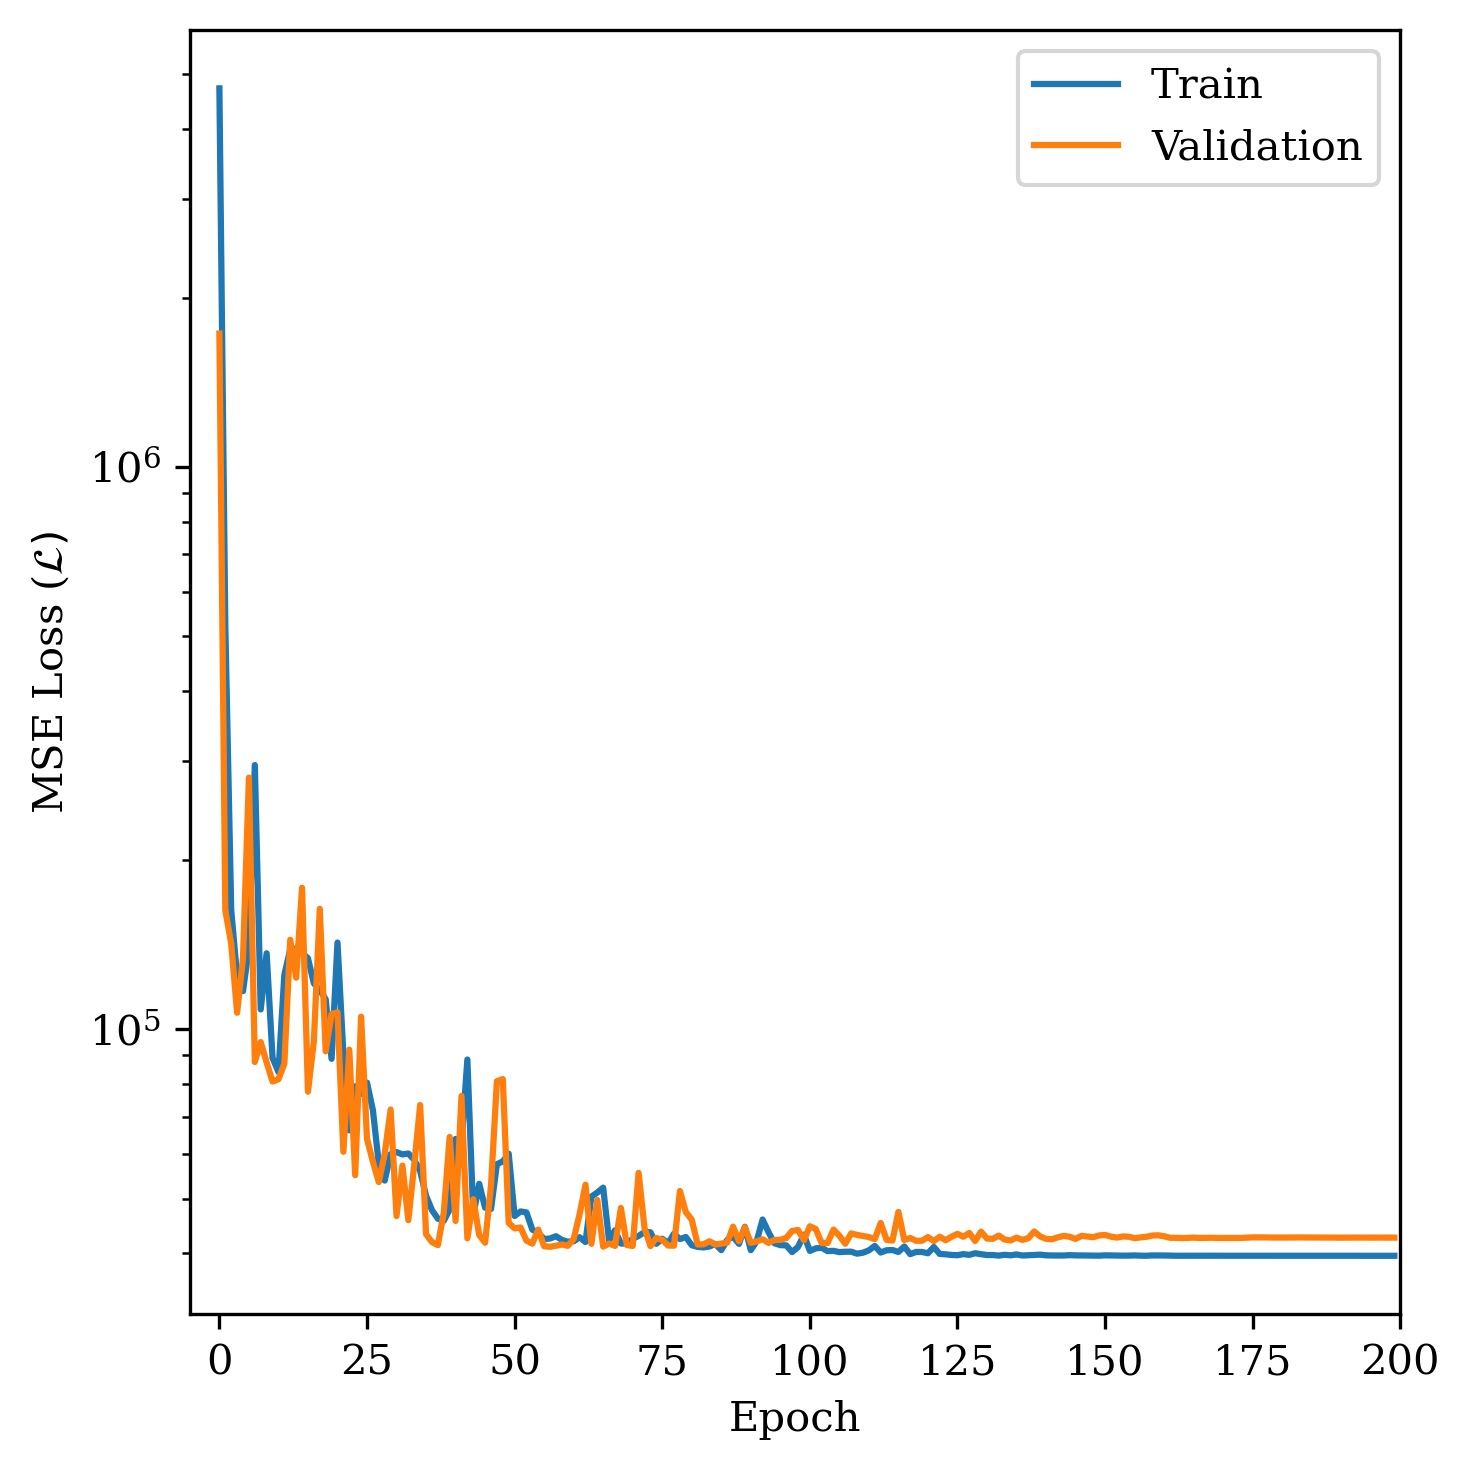

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Epoch vs R^2
plt.figure(dpi=300, figsize=(5,5)) 

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 10

plt.plot(np.array(train_losses), label='Train')
plt.plot(np.array(test_losses), label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(r'MSE Loss ($\mathcal{L})$')
plt.yscale("log") 
plt.xlim(-5,epoch_num)
plt.tight_layout() 

# Save model

In [12]:
best_model_path = f'{args.save_model_dir}/epoch_{args.epoch_num}.pt'  
torch.save(best_state_dict, best_model_path)

# Evaluation

Test R2 for E: 0.7142770290374756


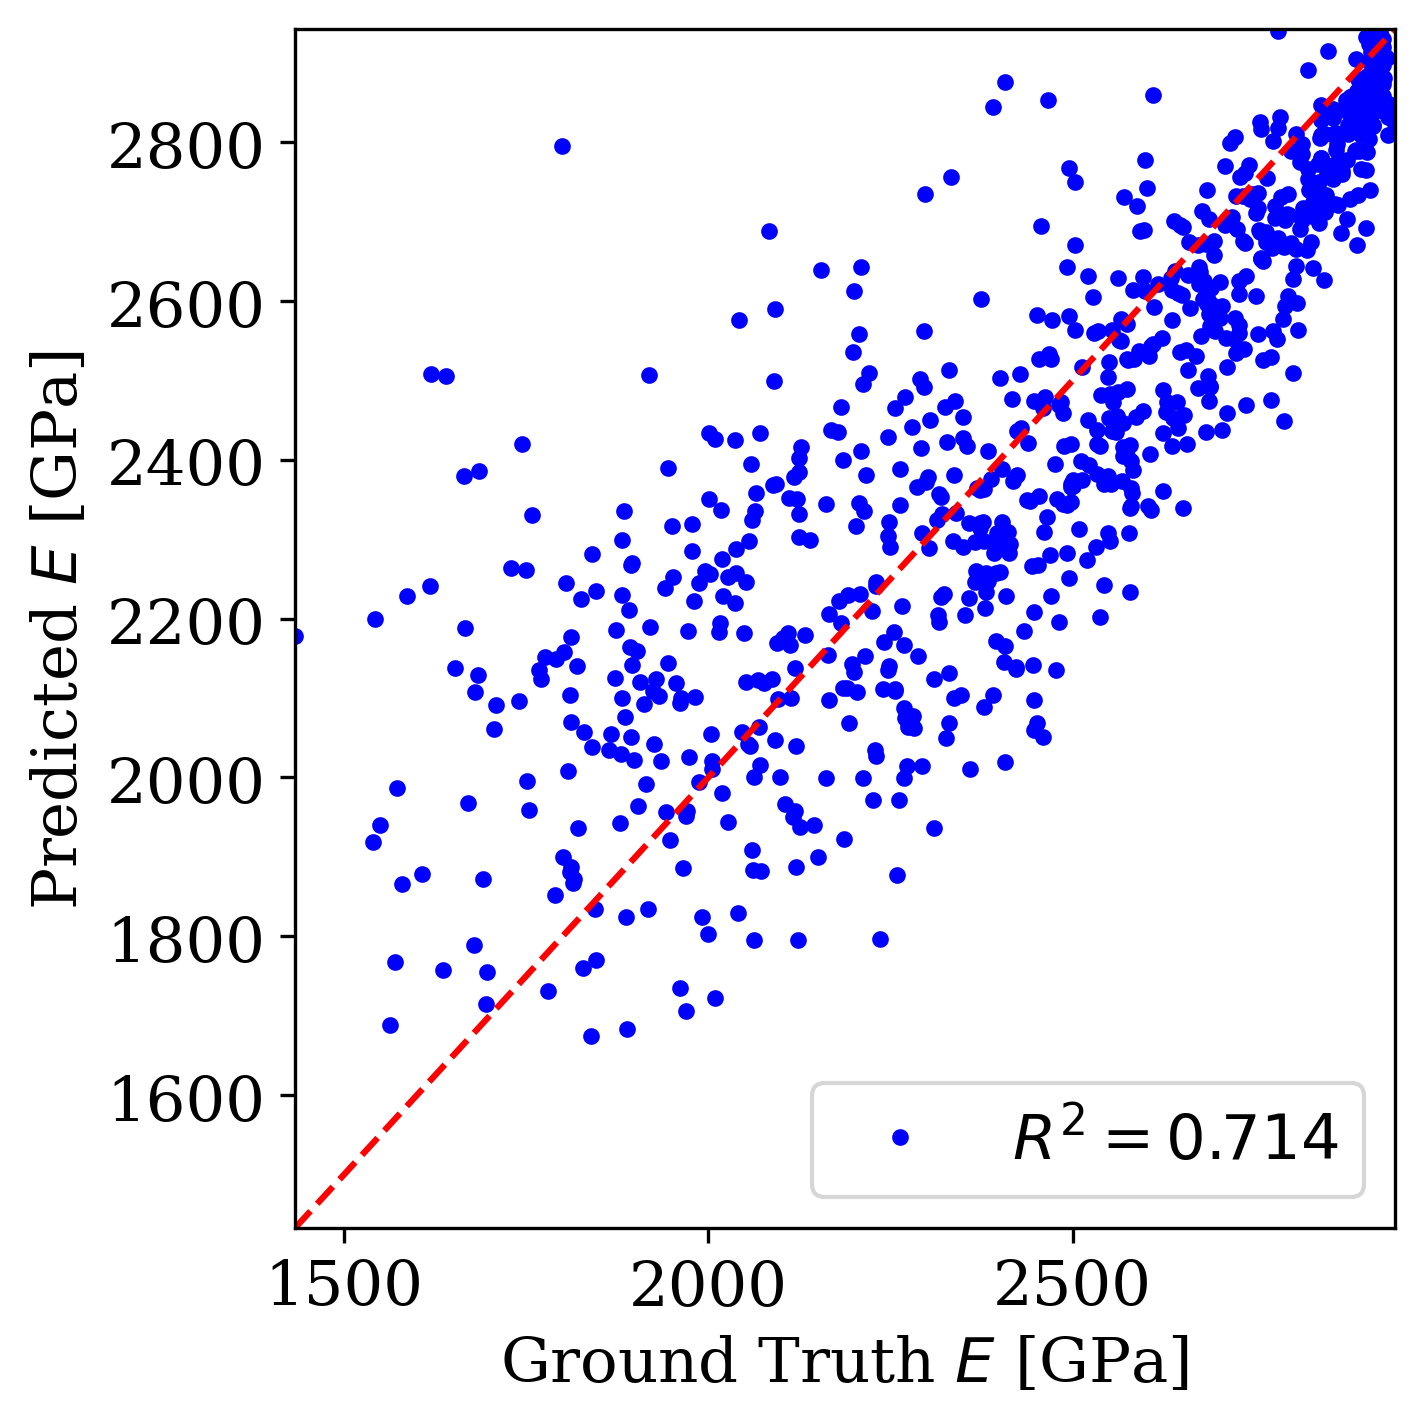

In [13]:
R2_K = evaluate_model(model, train_loader, device, args.cover_interval, overlap, args.save_model_dir)

Test R2 for E: 0.6731549501419067


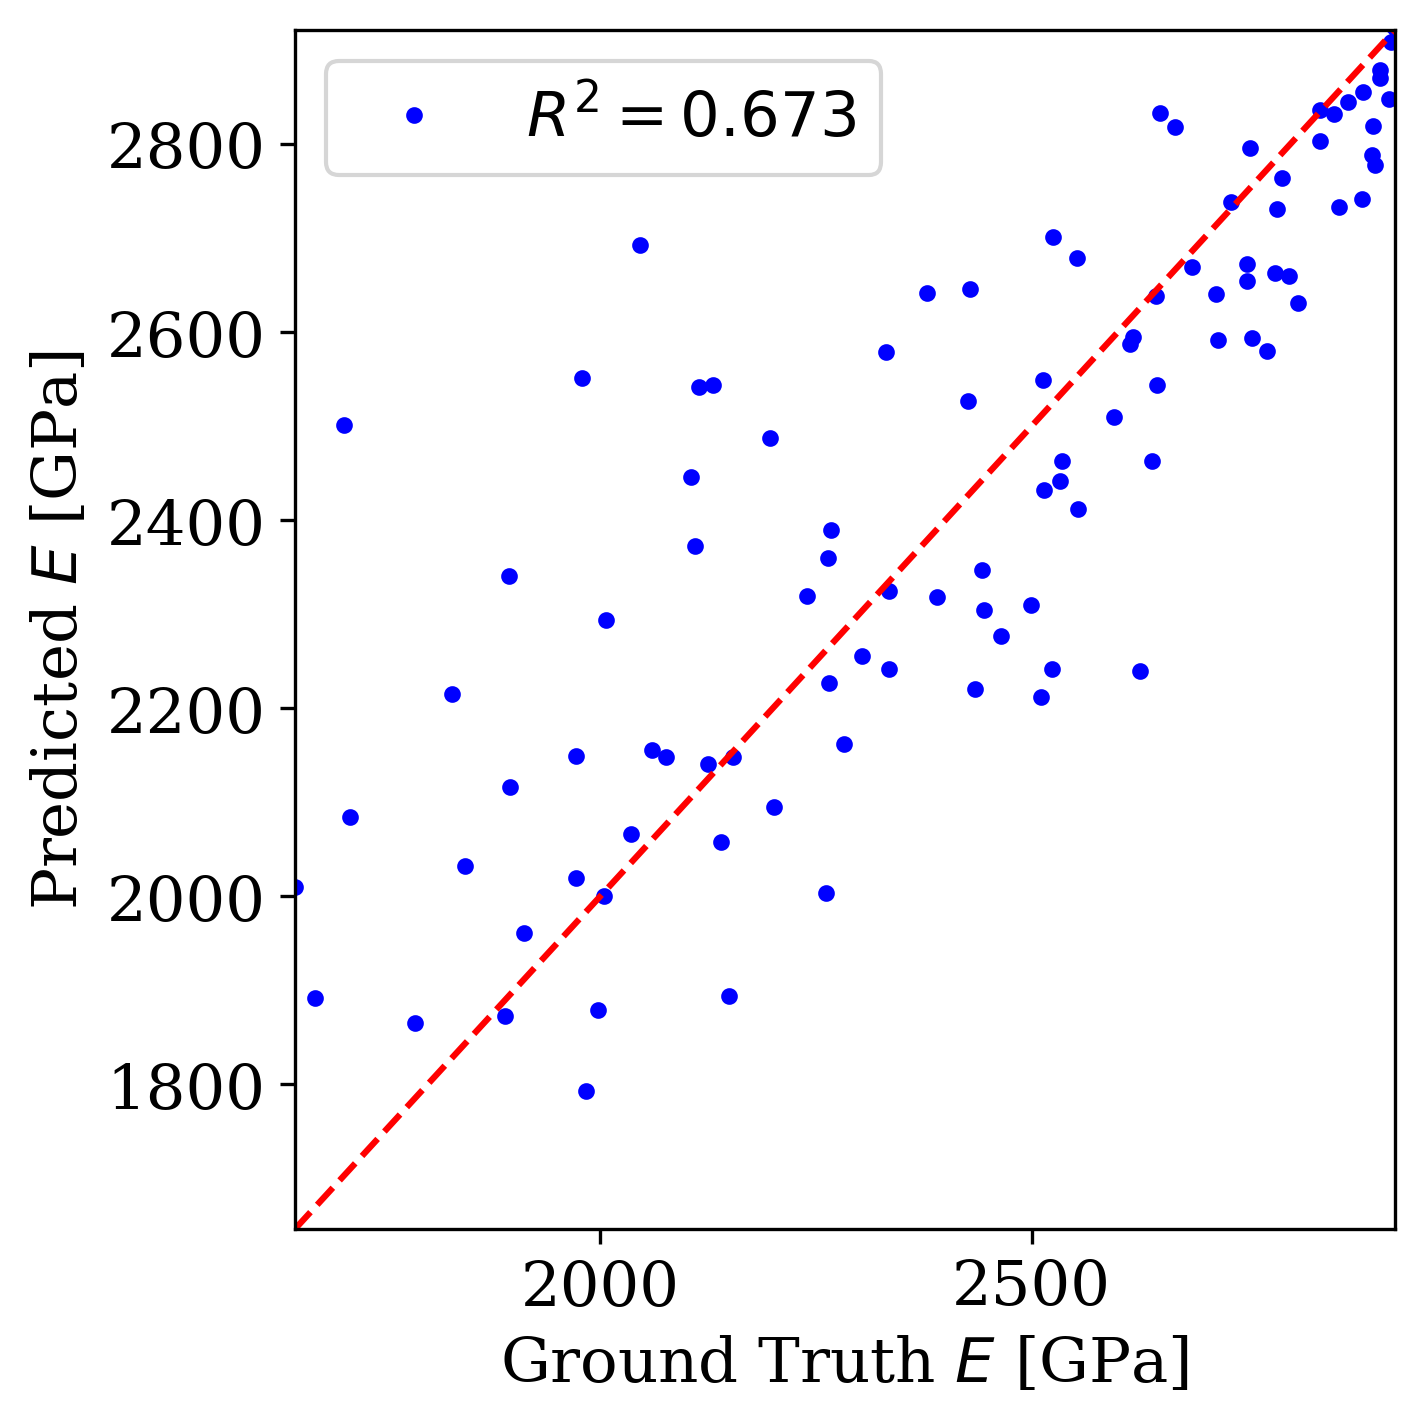

In [14]:
R2_K = evaluate_model(model, test_loader, device, args.cover_interval, overlap, args.save_model_dir)

Test R2 for E: 0.7410236597061157


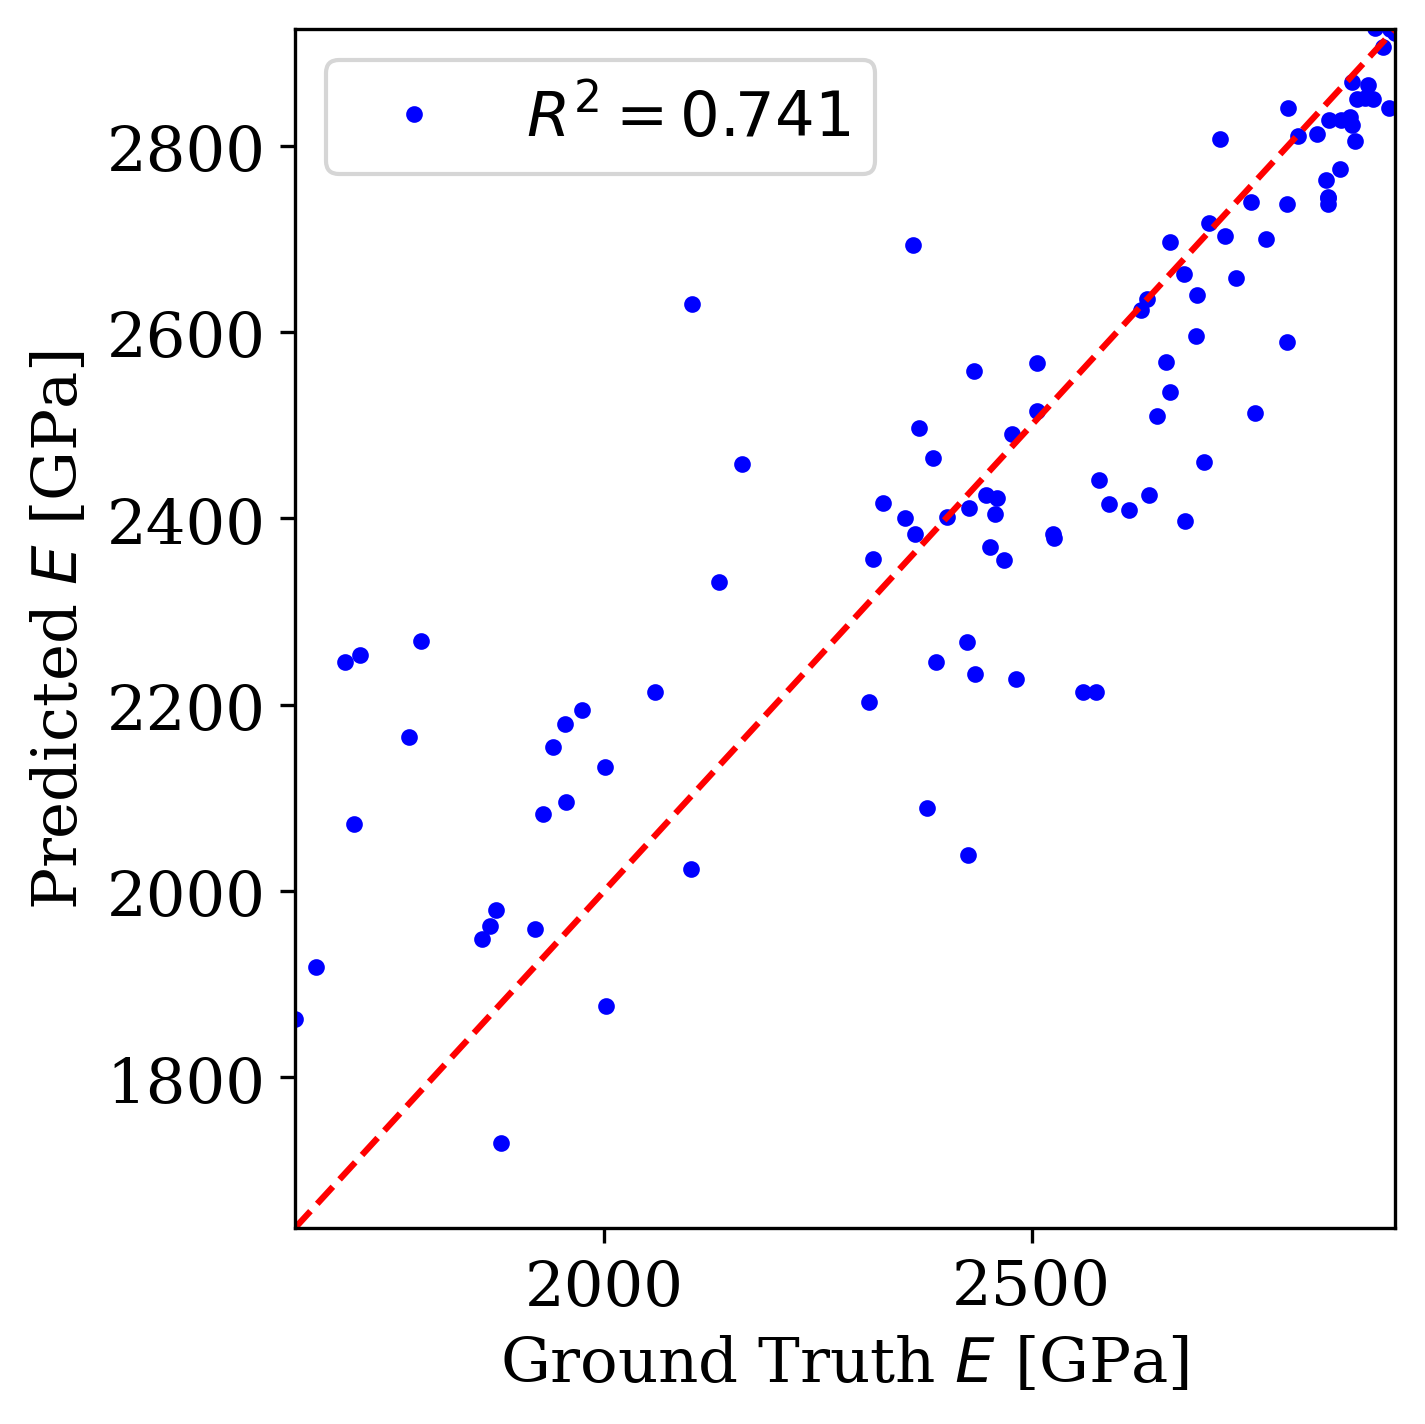

In [15]:
R2_K = evaluate_model(model, valid_loader, device, args.cover_interval, overlap, args.save_model_dir)